First import all the packages needed

In [2]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1.ergast import Ergast
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import warnings
import numpy as np
import scipy.special
import os

Here, all the rounds completed are put into an array so that the data from each can be taken
The names of the races are used - the locations normally - and are then found in the fastf1 package

In [3]:
warnings.filterwarnings('ignore')
os.makedirs('cache_dir', exist_ok=True)
ff1.Cache.enable_cache('cache_dir')

completed_rounds = [
    'Australia', 'China', 'Japan', 'Bahrain', 'Saudi Arabia', 'Miami', 'Emilia-Romagna', 'Monaco', 'Spain', 'Canada', 'Austria', 'Great Britain', 'Belgium', 'Hungary'
]

Be warned, this next part takes a lot longer to run, here all the data is loaded in

In [4]:
races_2025 = []
for gp in completed_rounds:
    try:
        session = ff1.get_session(2025,gp,'R')
        session.load()
        df_gp = session.results
        df_gp['GrandPrix'] = gp
        races_2025.append(df_gp)
    except Exception as e:
        print(f'Failed to load {gp}: {e}')
df_2025 = pd.concat(races_2025, ignore_index=True)
df_2025['DriverNumber'] = df_2025['DriverNumber'].astype(int)
df_2025['won'] = (df_2025['Position'] == 1).astype(int)

core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', 

In [8]:
driver_stats = df_2025.groupby('DriverNumber').agg({
    'Position' : ['mean', 'min', 'max'],
    'Points' : 'sum',
    'won' : 'sum',
    'GridPosition' : 'mean',
    'TeamName' : 'last',
    'Abbreviation' : 'last'
}).reset_index()

driver_stats.columns = [
    'DriverNumber', 'avg_pos', 'best_pos', 'worst_pos', 'total_points', 'wins', 'avg_grid', 'TeamName', 'Abbreviation'
]

df_train = df_2025.merge(driver_stats, on = 'DriverNumber', how = 'left')
features = [
    'avg_pos', 'best_pos', 'worst_pos', 'total_points', 'wins', 'avg_grid'
]

Now the Machine Learning part actually starts, using RandomForestClassifier and sklearn to build the prediction

In [10]:
X_train = df_train[features]
y_win = df_train['won']
y_position = df_train['Position']

win_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
win_clf.fit(X_train, y_win)

pos_reg = RandomForestRegressor(n_estimators=100, random_state=42)
pos_reg.fit(X_train, y_position)
X_predict = driver_stats[features]
driver_stats['win_prob'] = win_clf.predict_proba(X_predict)[:,1]
driver_stats['predicted_pos'] = pos_reg.predict(X_predict)
scaler = MinMaxScaler()
driver_stats['scaled_win_prob'] = scipy.special.softmax(driver_stats['win_prob'])
win_output = driver_stats[['Abbreviation', 'scaled_win_prob']].sort_values(by='scaled_win_prob', ascending = False)
driver_stats['predicted_pos'] = driver_stats['predicted_pos'].clip(1, 20)



In [11]:
top_10_output = (
    driver_stats[['Abbreviation', 'predicted_pos']].sort_values(by='predicted_pos').reset_index(drop=True)
)
top_10_output = top_10_output.head(10)
print('\nPredicted winner probabilities for Dutch GP: \n')
print(win_output.to_string(index=False, float_format='%.3f'))


Predicted winner probabilities for Dutch GP: 

Abbreviation  scaled_win_prob
         PIA            0.100
         NOR            0.096
         VER            0.075
         RUS            0.058
         ALB            0.039
         SAI            0.039
         HAM            0.039
         COL            0.039
         OCO            0.039
         LAW            0.039
         HUL            0.039
         TSU            0.039
         STR            0.039
         LEC            0.039
         ALO            0.039
         ANT            0.039
         GAS            0.039
         DOO            0.039
         HAD            0.039
         BOR            0.039
         BEA            0.039


In [12]:
print('\nPredicted winner probabilities for the Dutch GP: \n')
print(top_10_output.to_string(index=False, float_format='%.2f'))


Predicted winner probabilities for the Dutch GP: 

Abbreviation  predicted_pos
         PIA           2.35
         NOR           3.20
         RUS           4.47
         LEC           5.31
         VER           5.92
         HAM           7.46
         ALB          10.90
         ANT          11.43
         ALO          11.78
         HAD          12.00


Now a plot to help visualise the prediction
This part is a work in progress to help with the prediction

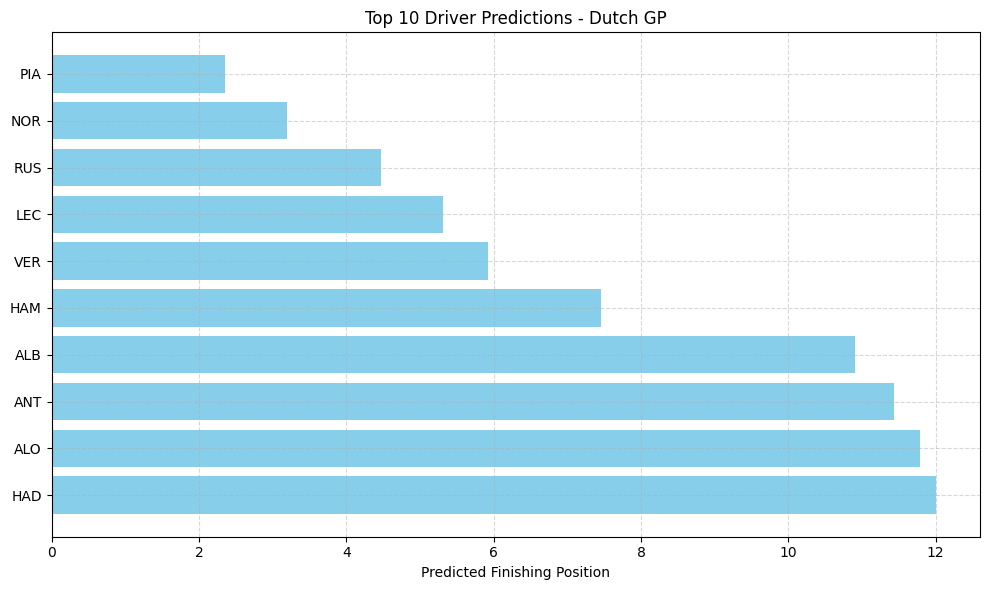

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(top_10_output['Abbreviation'],top_10_output['predicted_pos'],color='skyblue')
plt.xlabel('Predicted Finishing Position')
plt.title('Top 10 Driver Predictions - Dutch GP')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()